In [2]:
from keras.layers import (Bidirectional, Dense, Embedding, Input, Lambda, InputLayer, Reshape
                          , LSTM, RepeatVector, TimeDistributed)
from keras.models import Model, Sequential
from tcn import TCN

Using TensorFlow backend.


In [13]:
MAX_SEQUENCE_LEN = 50
MAX_NUM_WORDS = 5000

input_layer = Input(shape=(MAX_SEQUENCE_LEN,))
#encoder = Reshape((MAX_SEQUENCE_LEN, 1))(input_layer)
encoder = Embedding(MAX_NUM_WORDS, 64)(input_layer)
encoder = TCN(name='latent', return_sequences=False, nb_stacks=2, dilations=[2**n for n in range(7)])(encoder)
decoder = RepeatVector(MAX_SEQUENCE_LEN, name='decoder')(encoder)
decoder = TCN(return_sequences=True, nb_stacks=2, dilations=[2**n for n in range(7)])(decoder)
output_layer = TimeDistributed(Dense(MAX_NUM_WORDS, activation='softmax'))(decoder)
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 64)       320000      input_2[0][0]                    
__________________________________________________________________________________________________
latent_initial_conv (Conv1D)    (None, 50, 64)       4160        embedding_2[0][0]                
__________________________________________________________________________________________________
latent_dilated_conv_1_tanh_s0 ( (None, 50, 64)       8256        latent_initial_conv[0][0]        
__________________________________________________________________________________________________
activation

In [4]:
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from nltk.corpus import reuters
from itertools import chain

In [5]:
X_train = np.random.randint(0, 10, (1000, 10))
X_train_onehot = to_categorical(X_train)

In [6]:
def iter_labels(selection='train'):
    for fid in reuters.fileids():
        if fid.startswith(selection):
            for sent in reuters.sents(fid):
                yield reuters.categories(fid)
labels_train = np.array(list(iter_labels('train')))
labels_test = np.array(list(iter_labels('test')))

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer().fit(labels_train)
y_train = mlb.transform(labels_train)
y_test = mlb.transform(labels_test)

In [8]:
def iter_sents(selection='train'):
    for fid in reuters.fileids():
        if fid.startswith(selection):
            for sent in reuters.sents(fid):
                yield " ".join(sent)
data_train = np.array(list(iter_sents('train')))
data_test = np.array(list(iter_sents('test')))

In [10]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data_train)

X_train = tokenizer.texts_to_sequences(data_train)
X_test = tokenizer.texts_to_seque nces(data_test)

X_train = pad_sequences(X_train, MAX_SEQUENCE_LEN)
X_test = pad_sequences(X_test, MAX_SEQUENCE_LEN)

In [11]:
X_hat = X_train
X_hat_oh = to_categorical(X_hat, MAX_NUM_WORDS)

In [19]:
history = model.fit(X_hat, X_hat_oh, batch_size=32, epochs=10, shuffle=True)

Epoch 1/10
40277/40277 [==============================] - 3314s 82ms/step - loss: 2.1554 - acc: 0.6169
Epoch 2/10
40277/40277 [==============================] - 3530s 88ms/step - loss: 2.0708 - acc: 0.6259
Epoch 3/10
40277/40277 [==============================] - 3051s 76ms/step - loss: 2.0058 - acc: 0.6339
Epoch 4/10
40277/40277 [==============================] - 2928s 73ms/step - loss: 1.9525 - acc: 0.6401
Epoch 5/10
40277/40277 [==============================] - 3115s 77ms/step - loss: 1.9068 - acc: 0.6459
Epoch 6/10
40277/40277 [==============================] - 3163s 79ms/step - loss: 1.8719 - acc: 0.6502
Epoch 7/10
40277/40277 [==============================] - 3076s 76ms/step - loss: 1.8413 - acc: 0.6542
Epoch 8/10
40277/40277 [==============================] - 3286s 82ms/step - loss: 1.8091 - acc: 0.6584
Epoch 9/10
40277/40277 [==============================] - 3407s 85ms/step - loss: 1.7853 - acc: 0.6615
Epoch 10/10
40277/40277 [==============================] - 3398s 84ms/ste

In [20]:
tokenizer.sequences_to_texts(np.argmax(model.predict(X_hat[:10], verbose=1), axis=2)[:10])

10/10 [==============================] - 0s 25ms/step


['the said said the the the the the in in the in of the year and and to in the the year and in and they not been to to said in its world tax',
 'the annual sales as the cattle will be on this year',
 'the said said the to to of 1 pct of of the years of of the 1986 in the year of 6 3 mln at 5 dlrs in the same 1986 in year',
 'to will be that oil oil prices this it as in the banks',
 'however said said will be that for to to as of this to that they be that as opec would made to of early',
 'the the were to of 5 mln mln bpd year and with of 1 5 pct and and a pct same and of the and of sugar and and saying',
 'there also see to to for of of of that would be to on as as they be in permission conditions',
 'in addition of the same of of the the program is to a result for of of price as other',
 'bankamerica said crude oil prices rose to a to 20 ounce from 100 ounces',
 'the said said that to to the the and and for and are be at the of of 1 30 to 1 2 dlrs per tonne and and to be to']

In [21]:
tokenizer.sequences_to_texts(X_hat[:10])

['cocoa review continued throughout the week in the cocoa zone the drought since early january and improving prospects for the coming temporao although normal levels have not been restored smith said in its weekly review',
 'the dry period means the temporao will be late this year',
 'for the week ended february 22 were 155 221 bags of 60 kilos making a cumulative total for the season of 5 93 mln against 5 81 at the same stage last year',
 'again it seems that cocoa delivered earlier on was included in the figures',
 'smith said there is still some doubt as to how much old crop cocoa is still available as harvesting has come to an end',
 'with total crop estimates around 6 4 mln bags and sales at almost 6 2 mln there are a few bags still in the hands of farmers exporters and processors',
 'there are doubts as to how much of this cocoa would be fit for export as are now in obtaining certificates',
 'in view of the lower quality over recent weeks farmers have sold a good part of their co

In [27]:
model_enc = Model(input_layer, encoder)
vecs = model_enc.predict(X_hat[:1000], verbose=True)

1000/1000 [==============================] - 4s 4ms/step


In [28]:
from sklearn.manifold import TSNE
vecs_reduced = TSNE().fit_transform(vecs)

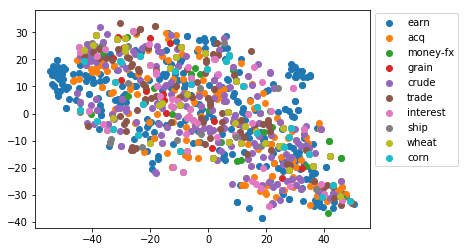

In [29]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

categories = [(cat, len(reuters.fileids(categories=cat))) for cat in reuters.categories()]
topn = [cat for cat, _ in sorted(categories, key=lambda x: -x[1])[:10]]

indexes = []
for cat in topn:
    index = []
    for pos, cats in enumerate(labels_train[:1000]):
        if cat in cats:
            index.append(pos)
    indexes.append((cat, index))

for cat, index in indexes:
    plt.scatter(vecs_reduced[index,0], vecs_reduced[index,1], label=cat)
plt.legend(bbox_to_anchor=(1, 1.01))